# 🏞️ Part 2: Data Exploration

In [1]:
# Import relevant libraries
import torch 
import torchvision
from torch import nn 
from torchvision import transforms
from torch.utils import data
import random
import matplotlib.pyplot as plt
import time
from IPython import display
import numpy as np
random.seed(2021) # We set a seed to ensure our samples will be the same every time we run the code.

In [2]:
from helper import helper

## ⚗️ The Data Science Pipleine 
*This section will be repeated in both Part 2 and Part 3*

> What on earth is data science?! -- George Washington (probably not)

Seriously though, nowadays, in such a data-rich world, data science has become the new buzzword, the new cool kid in the block. But what exactly is it? Unfortunately, no one can really pin down a [rigourous definition](https://hdsr.mitpress.mit.edu/pub/jhy4g6eg/release/7) of data science. At the high level:

> Data science is the systematic extraction of novel information from data.

Good enough! With this definition, most practitioners can somewhat agree on a pipeline or flow. Here are the steps:
1. Identify your problem (What are you trying to do?)
2. Obtain your data (What resource do we have to work with?)
3. Explore your data (What does our data actually look like?)
4. Prepare your data (How do we clean/wrangle our data to make it ingestible?)
5. Model your data (How do we automate the process of drawing out insights?)
6. Evaluate your model (How good are our predictions?)
7. Deploy your model (How can the wider-user base access these insights?)

The 7th step is out-of-scope for this workshop, but we well be exploring the other steps to varying degrees:
* Steps 1-4 will be explored in Part 2.
* Steps 5-6 will be explored in Part 3 and 4.


## Step 1: Identify Your Problem 
![cc](../images/confused_cat.jpg)

**Figure:** A day-to-day snapshot of a data scientist at work. ([source](https://s.keepmeme.com/files/en_posts/20200925/confused-cat-looking-at-computer-with-a-lot-of-question-marks-meme-861f3efff59aedea603e35b8c3c059f0.jpg))

The problem:
* Your boss comes up to you and gives you a stack of black & white photos
* You get told you need to identify what item of clothing each photo represents (eg. t-shirt)
* You get a stack of 70,000 labelled picture to give you an idea of the task

*What do you do?!* You can label them by hand if there are only 100 or 1000 unlabelled images. But what if there are 1,000,000? This manual labelling is not tenable in the long term.

Why use automated image recognition?
* **Scalable** -- provided you have a reasonable model and enough computational resources, getting a computer to label images is ***a lot*** easier.
* **Consistent** -- the output of the model is going to be more consistent than any crack team of labelers you can assemble (we are but humans after all).

## Step 2: Obtain Your Data
Alright, you decided you probably won't manually label \* phew \*. What next? Lucky for you, your boss provided you with some initial information:
* There are 70,000 labelled images.
* Each image is an item of clothing.
* Each image is a 28x28 sized image (784 pixels in total).
* Each pixel is black and white, and has a value between 0 and 255 indicating the brightness of the pixel
* There are a total of 10 types of items of clothing.

| Label | Type of Clothing |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat | 
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle Boot |

For example, the following is an image of a boot:

![Boot](../images/boot.png)

In fact, the dataset we are working with is called the [Fashion MNIST](https://www.kaggle.com/zalando-research/fashionmnist). We will write a function below to extract the data into train and test sets (`train_iter` and `test_iter` respectively). Don't worry too much about the details of the function, the key point is the input parameters.

The function `load_data_fashion_mnist` takes in two input arguments: `batch_size` and `n_workers`. The recommended number will be different depending on whether you are running this on mybinder or your own machine.

#### For mybinder users
You have a max of 2GB of Random Access Memory (RAM), so to ensure things work smoothly, we need to make the `batch_size` larger and `n_workers` smaller, we recommend:
* `batch_size = 1024`
* `n_workers = 0`

#### For those on their own machines
You should have more resources than mybinder. Smaller batch sizes means less epochs need to be run for the same accuracy (faster training overall). We can expand on the number of worker nodes as well:
* `batch_size = 256`
* `n_workers = 4`

Note if you are using GPU acceleration, you may choose to use more worker nodes. See the Appendix for more detail.

In [3]:
# First define the function without running it
def load_data_fashion_mnist(batch_size, n_workers):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data",
                                                    train=True,
                                                    transform=trans,
                                                    download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data",
                                                   train=False,
                                                   transform=trans,
                                                   download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=n_workers),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=n_workers))

# Then execute the function here
batch_size = 1024  # Set to 256 on your own device
n_workers = 0      # Set to 4 on your own device
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size, n_workers = n_workers)

Great! We have read:
* 60,000 images into `train_iter`
* 10,000 images into `test_iter`

Let's see if we can have a look at it with a `print()` statement

In [4]:
print(test_iter)

Weird, it's not printing out the mini-batch, but rather some weird thing called a `DataLoader object`. There's actually a really good reason for this! If we are dealing with big datasets, reading the data in as a table would mean we need to store the entire thing in memory (RAM) - this can be up to 10-20GB which can cripple a normal computer! Instead we use the `DataLoader object` to read in the dataset *as we need it* (and discarding it otherwise). This might be a bit slower, but far more manageable in terms of memory resources. This means there's a very particular way to extract a single example, which we will attempt to do below:

In [5]:
# First we extract a few random batches (say 3), each of which will have up to your set batch_size (eg. 1024 for mybinder)
sampled_batches = random.sample(list(train_iter), 3)
print("The number of mini-batches we have extracted are:", len(sampled_batches))

# Second we select a single batch to look at, let's say the 3rd one
batch_no = 2
## 0 denotes the predictors
## 1 denotes the labels
predictor = sampled_batches[batch_no][0]
label = sampled_batches[batch_no][1]
print("Out of the", len(sampled_batches), "mini-batches, we have selected the", batch_no + 1, "th one.")
print("The number of images in the mini-batch we selected are:" , len(predictor), " and ", len(label), ". Note these two values should be equal.")

# Third, we select a single example in the batch, let's say the 100th one
example_no = 99
single_predictor = predictor[example_no]
single_label = label[example_no]
print("The shape of the predictor", single_predictor.shape)
print("The shape of the label", single_label.shape)

The number of mini-batches we have extracted are: 3
Out of the 3 mini-batches, we have selected the 3 th one.
The number of images in the mini-batch we selected are: 1024  and  1024 . Note these two values should be equal.
The shape of the predictor torch.Size([1, 28, 28])
The shape of the label torch.Size([])


Does this make sense?

Importantly, in the last two lines, we have printed the `shape` of our selected example/image:
* The predictor has `[1, 28, 28]`:
    * The `1` represents the number of channels (since it's black and white this is only 1. For colour, it's 3 RGB).
    * The `28` and `28` represents the dimension of the image (28x28)
* The label has `[]`: this means it's just a number

Let's try to show the predictor and label:

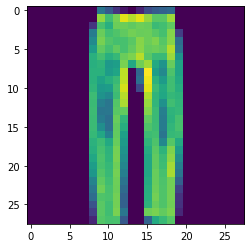

This shows an image of:  1


In [6]:
plt.imshow(single_predictor[0]) # print only the one channel of BW
plt.show()

print("This shows an image of: ", int(single_label))

Check if this makes sense according to the label table above!

## Step 3: Explore Your Data
The Fashion MNIST data we have is relatively clean. Not much needs to be done here. But let's have a look at the class distribution of the train/test data. It is important that the training data has enough examples to 'learn' the patterns of each class. Ideally a balanced class (with similar number of examples for each) is best.

Let's see what the class distribution is like.

In [7]:
def data_explore(data_iter):
    class_count = helper.Accumulator(10)
    for i, (X, y) in enumerate(data_iter):
        current_counter = torch.bincount(y)
        class_count.add(current_counter[0], current_counter[1], current_counter[2], current_counter[3], current_counter[4],
                  current_counter[5], current_counter[6], current_counter[7], current_counter[8], current_counter[9]) # This is bad coding practice, don't do this!
    for i in range(10):
        print("Class", i, "has", int(class_count.__getitem__(i)), "images")
        
    return
        
print("Train Data:")
data_explore(train_iter)
print("Test Data")
data_explore(test_iter)

Train Data:
Class 0 has 6000 images
Class 1 has 6000 images
Class 2 has 6000 images
Class 3 has 6000 images
Class 4 has 6000 images
Class 5 has 6000 images
Class 6 has 6000 images
Class 7 has 6000 images
Class 8 has 6000 images
Class 9 has 6000 images
Test Data
Class 0 has 1000 images
Class 1 has 1000 images
Class 2 has 1000 images
Class 3 has 1000 images
Class 4 has 1000 images
Class 5 has 1000 images
Class 6 has 1000 images
Class 7 has 1000 images
Class 8 has 1000 images
Class 9 has 1000 images


![](../images/thanos.jpg)

([source](https://i.kym-cdn.com/entries/icons/original/000/027/257/perfectly-balanced-as-all-things-should-be.jpg))

In reality, your data won't be this perfect, it's always worth checking and understanding class balances!

## Step 4: Prepare Your Data
This was something we have previously alluded to, but we have 70,000 labelled examples. Perfect! Do we throw them all into the training/fitting process of the model?

The answer is **NO**. Why is that though? Doesn't more data = better model?

![yesbutno](../images/yesbutno.jpg)

The reason lies in a concept known as **overfitting**. Remember, our goal is to make sure the model works well on hiterto unseen data (ie. unlabelled data). If we just throw all the data we have into the train process, then we won't have access to an independent dataset to evaluate the model. Later on, we will see how the test data can be used to assess overfitting. For now, just remember that it is vital that we have an (representative) subset of the labelled data set aside for evaluation. For the purposes of this example, 60,000 images will be used to train and 10,000 images will be used to test:
* `Train` -- this is the data we use to fit the model (n=60,000)
* `Validate` -- we will not be using this today to tune hyper-parameters
* `Test` -- this is the data we use to determine the model performance (n=10,000)

#### Aside: Validate \& Hyperparameters
**Hyperparameters** are parameters of the model that the user has to provide (as opposed to parameters the model finds such as the weights of a neural network). Examples of this might be the learning rate of the gradient descent method (denoted by `lr` later). Since these parameters have to be provided by the user, we need to decide on its value somehow. In the absence of any external information (eg. someone told us a particular learning rate is really good), we use the validate set (independent of train and test) to set these. In the example of learning rate, we may try the learning rate in increments of `0.1` between `0.1` and `0.9`. Then we choose the hyperparameter which gives us the best performance when assessed against the validate set.

*For the purpose of this tutorial, we will not do any hyperparameter tuning, so a validate set was not used.*

---